<a href="https://colab.research.google.com/github/Prakash-Nagamani/summer_intern/blob/main/movie_recommendation_system_using_KNN_Algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Dependencies and Dataset**

In [ ]:
import pandas as pd
import numpy as np
import difflib
import matplotlib.pyplot as plt
import operator
from scipy import spatial
import pdb
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
%matplotlib inline

In [ ]:
movies_dataset = pd.read_csv("/content/movies_metadata.csv")
keywords_dataset = pd.read_csv("/content/keywords.csv.xls")
credits_dataset = pd.read_csv("/content/credits.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# **Data Exploration and Cleaning** 

In [ ]:
movies_dataset.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [ ]:
credits_dataset.head(1)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862


In [ ]:
movies_dataset.drop(['poster_path','spoken_languages','status'  ,'video','revenue','adult','belongs_to_collection','budget','homepage','imdb_id'], axis = 1,inplace=True)

In [ ]:
credits_dataset['crew'] = credits_dataset['crew'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x if i['job'] == 'Director'] if isinstance(x, list) else [])
credits_dataset.rename(columns = {'crew':'Director'}, inplace = True)

In [ ]:
index = movies_dataset.index
condition = movies_dataset['id'].str.contains(pat = '-')
wrong = index[condition]
wrong
movies_dataset.drop(wrong, inplace = True)
# movies_dataset['id'][35587]

In [ ]:
movies_dataset.head(1)

,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,tagline,title,vote_average,vote_count
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,NaN,Toy Story,7.7,5415.0


Note: The above list "wrong" contains the indices of movies_dataset IDs that are in date format instead of integer

In [ ]:
# Converting JSON to List 
credits_dataset['cast'] = credits_dataset['cast'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_dataset['production_companies'] = movies_dataset['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_dataset['genres'] = movies_dataset['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
keywords_dataset['keywords'] = keywords_dataset['keywords'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_dataset['production_countries'] = movies_dataset['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


In [ ]:
# converting ID column type object to integer
movies_dataset['id'].dtypes
movies_dataset['id'] = movies_dataset['id'].astype(str).astype(int)

In [ ]:
# Merging all three datasets(credits_dataset,movies_dataset,keywords_dataset) using ID.
movies_dataset['id'] = movies_dataset['id'].astype(int)
movies = movies_dataset.merge(credits_dataset,on='id',how='left')
movies = movies.merge(keywords_dataset,on='id',how='left')
movies.head(1)


,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,tagline,title,vote_average,vote_count,cast,Director,keywords
0,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,81.0,NaN,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",[John Lasseter],"[jealousy, toy, boy, friendship, friends, riva..."


In [ ]:
# Removing all the movie rows with less than 6 votes. (Due to insufficient RAM. We Removed values less than 6) 
zero_votes = []
for i,j in zip(movies.index,movies.vote_count):
  if j<6:
    zero_votes.append(i)

zero_votes = list(set(zero_votes))
len(zero_votes)
movies.drop(zero_votes,axis=0,inplace=True)

In [ ]:
# Removing all the movie rows with empty genres list.
zero_genres = []
for i,j in zip(movies.index,movies.genres):
  if len(j) == 0:
    zero_genres.append(i)
len(zero_genres)

313

In [ ]:
movies.drop(zero_genres,axis=0,inplace=True)

# **Working with Genres**

In [ ]:
# Function to convert list into binary list.
def binary_genres(x):
    binaryList = []
    for genre in genre_list:
        if genre in x:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList
def binary_cast(x):
    binaryList = []
    for cast in lis_cast_bin:
        if cast in x:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList
def binary_director(x):
    binaryList = []
    for director in director_list:
        if director in x:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList
def binary_keywords(x):
    binaryList = []
    for key in keywords_list_bin:
        if key in x:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

In [ ]:
movie_genre_popularity = pd.DataFrame()
movie_genre_popularity['genres'] = movies.genres
movie_genre_popularity['original_title'] = movies.original_title
movie_genre_popularity['popularity'] = movies.popularity

movie_genre_popularity

,genres,original_title,popularity
0,"[Animation, Comedy, Family]",Toy Story,21.946943
1,"[Adventure, Fantasy, Family]",Jumanji,17.015539
2,"[Romance, Comedy]",Grumpier Old Men,11.7129
3,"[Comedy, Drama, Romance]",Waiting to Exhale,3.859495
4,[Comedy],Father of the Bride Part II,8.387519
...,...,...,...
46614,"[Comedy, Fantasy]",Nouvelles luttes extravagantes,0.225432
46616,"[Crime, Drama, Thriller]",Maa,1.559596
46619,"[Horror, Mystery, Thriller]",House of Horrors,0.222814
46623,"[Drama, Action, Romance]",Robin Hood,5.683753


In [ ]:
movie_genre_popularity['popularity'].dtype

dtype('O')

In [ ]:
movie_genre_popularity['popularity'] = movie_genre_popularity['popularity'].astype(float)
movie_genre_popularity.sort_values('popularity',ascending=False,inplace=True)
movie_genre_popularity

,genres,original_title,popularity
30876,"[Family, Animation, Adventure, Comedy]",Minions,547.488298
33535,"[Action, Adventure, Fantasy]",Wonder Woman,294.337037
43376,"[Family, Fantasy, Romance]",Beauty and the Beast,287.253654
44798,"[Action, Crime]",Baby Driver,228.032744
24603,"[Adventure, Family, Animation, Action, Comedy]",Big Hero 6,213.849907
...,...,...,...
36139,[Horror],Slime City,0.000001
19845,"[Action, Thriller, Drama]",Midnight Man,NaN
29676,"[Animation, Science Fiction]",マルドゥック・スクランブル 排気,NaN
35970,"[TV Movie, Action, Horror, Science Fiction]",Avalanche Sharks,NaN


In [ ]:
movie_genre_popularity_romcom = movie_genre_popularity

In [ ]:
# Filtering top 15 rom com movies.
c = 0
ind_romcom = []
for i,j in zip(movie_genre_popularity_romcom['genres'],movie_genre_popularity_romcom.index):
  if "Romance" in i and "Comedy" in i :
    ind_romcom.append(j)
    c+=1
  if c==15:
    break
# ind_romcom 

In [ ]:
movie_genre_popularity_romcom = movie_genre_popularity_romcom.loc[ind_romcom]
movie_genre_popularity_romcom

,genres,original_title,popularity
351,"[Comedy, Drama, Romance]",Forrest Gump,48.307194
10357,"[Comedy, Drama, Romance]",Dilwale Dulhania Le Jayenge,34.457024
43359,"[Comedy, Drama, Romance]",The Big Sick,23.424794
46600,"[Family, Animation, Romance, Comedy]",In a Heartbeat,20.821780
5934,"[Comedy, Romance]",The Woman in Red,19.856025
42036,"[Comedy, Drama, Music, Romance]",La La Land,19.681686
2606,"[Comedy, Romance]",American Pie,18.344227
1797,"[Action, Adventure, Comedy, Romance]",Six Days Seven Nights,18.324219
1195,"[Comedy, Drama, Romance]",Annie Hall,18.146043
43958,"[Romance, War, Comedy, Drama]",Their Finest,17.958512


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


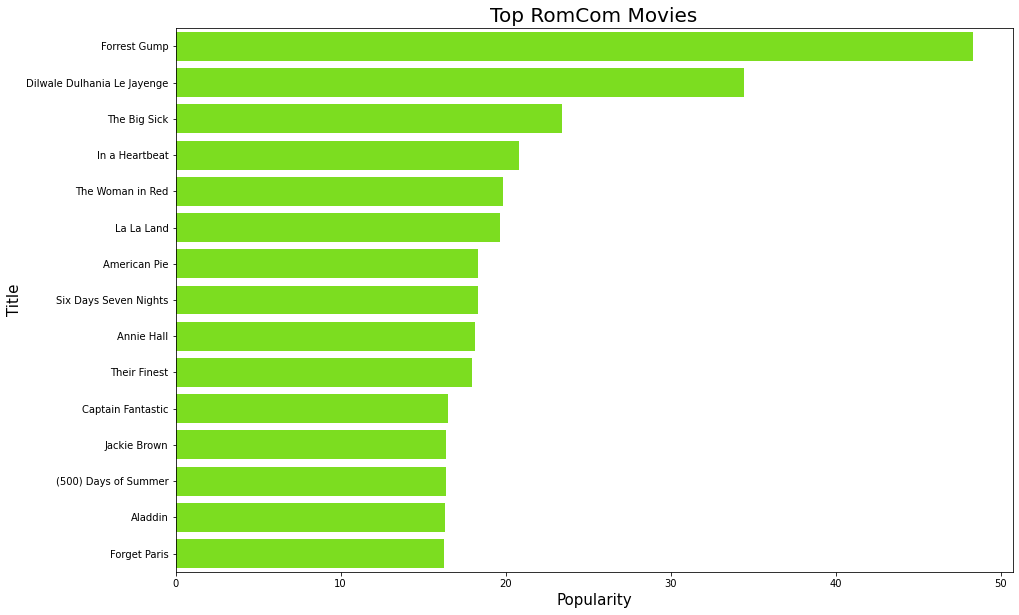

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]

romcom_graph = sns.barplot( movie_genre_popularity_romcom["popularity"],movie_genre_popularity_romcom.original_title.values, color='lawngreen')
romcom_graph.set_xlabel("Popularity", fontsize = 15)
romcom_graph.set_ylabel("Title", fontsize = 15)
romcom_graph.set_title("Top RomCom Movies", fontsize = 20)
plt.show()

**Graph 1**

> The above Bar Chart shows the titles of the **Top Romance Comedy Movies** according to their popularity.


In [ ]:
# Filtering top 15 Action Drama movies.
movie_genre_popularity_actdrama = movie_genre_popularity
c = 0
ind_actdrama = []
for i,j in zip(movie_genre_popularity_actdrama['genres'],movie_genre_popularity_actdrama.index):
  if "Action" in i and "Drama" in i :
    ind_actdrama.append(j)
    c+=1
  if c==15:
    break
# ind_actdrama 
movie_genre_popularity_actdrama = movie_genre_popularity_actdrama.loc[ind_actdrama]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


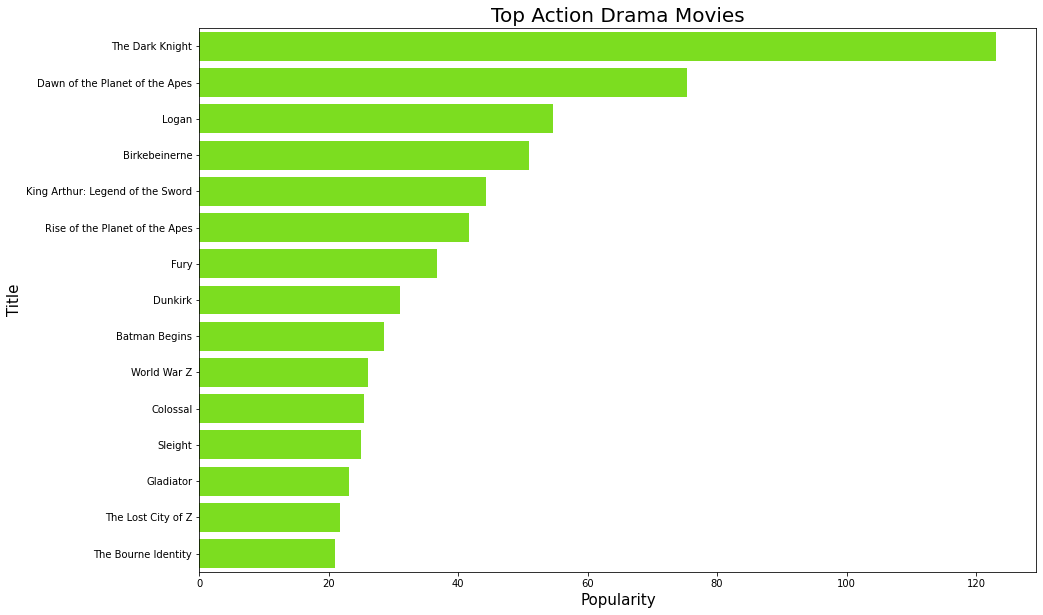

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]

actdrama_graph = sns.barplot( movie_genre_popularity_actdrama["popularity"],movie_genre_popularity_actdrama.original_title.values, color='lawngreen')
actdrama_graph.set_xlabel("Popularity", fontsize = 15)
actdrama_graph.set_ylabel("Title", fontsize = 15)
actdrama_graph.set_title("Top Action Drama Movies", fontsize = 20)
plt.show()

**Graph 2**

> The above Bar Chart shows the titles of the **Top Action Drama Movies** according to their popularity.


In [ ]:
# Filtering top 15 Thriller Crime movies.
movie_genre_popularity_thrillercrime = movie_genre_popularity
c = 0
ind_crithri = []
for i,j in zip(movie_genre_popularity_thrillercrime['genres'],movie_genre_popularity_thrillercrime.index):
  if "Thriller" in i or "Crime" in i :
    ind_crithri.append(j)
    c+=1
  if c==15:
    break
# ind_crithri 
movie_genre_popularity_thrillercrime = movie_genre_popularity_thrillercrime.loc[ind_crithri]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


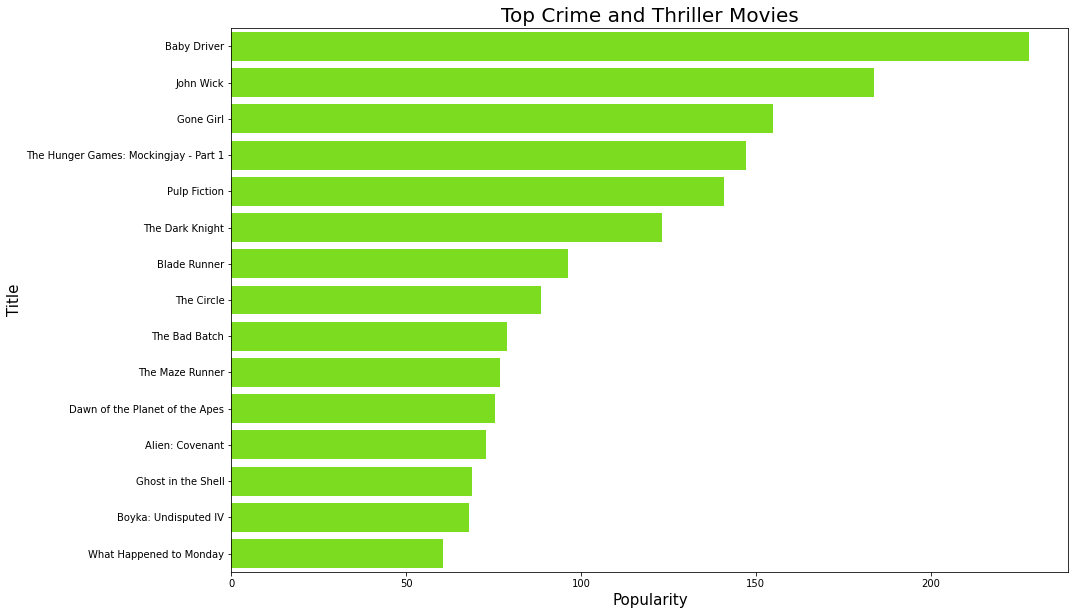

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]

crithri_graph = sns.barplot( movie_genre_popularity_thrillercrime["popularity"],movie_genre_popularity_thrillercrime.original_title.values, color='lawngreen')
crithri_graph.set_xlabel("Popularity", fontsize = 15)
crithri_graph.set_ylabel("Title", fontsize = 15)
crithri_graph.set_title("Top Crime and Thriller Movies", fontsize = 20)
plt.show()

**Graph 3**

> The above Bar Chart shows the titles of the **Top Crime Thriller Movies** according to their popularity.


In [ ]:
movie_genre_popularity_animation = movie_genre_popularity
c = 0
ind_ani = []
for i,j in zip(movie_genre_popularity_animation['genres'],movie_genre_popularity_animation.index):
  if "Animation" in i :
    ind_ani.append(j)
    c+=1
  if c==18:
    break
# ind_ani 
movie_genre_popularity_animation = movie_genre_popularity_animation.loc[ind_ani]
movie_genre_popularity_animation.drop([5505,42554,41402], axis=0, inplace=True)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


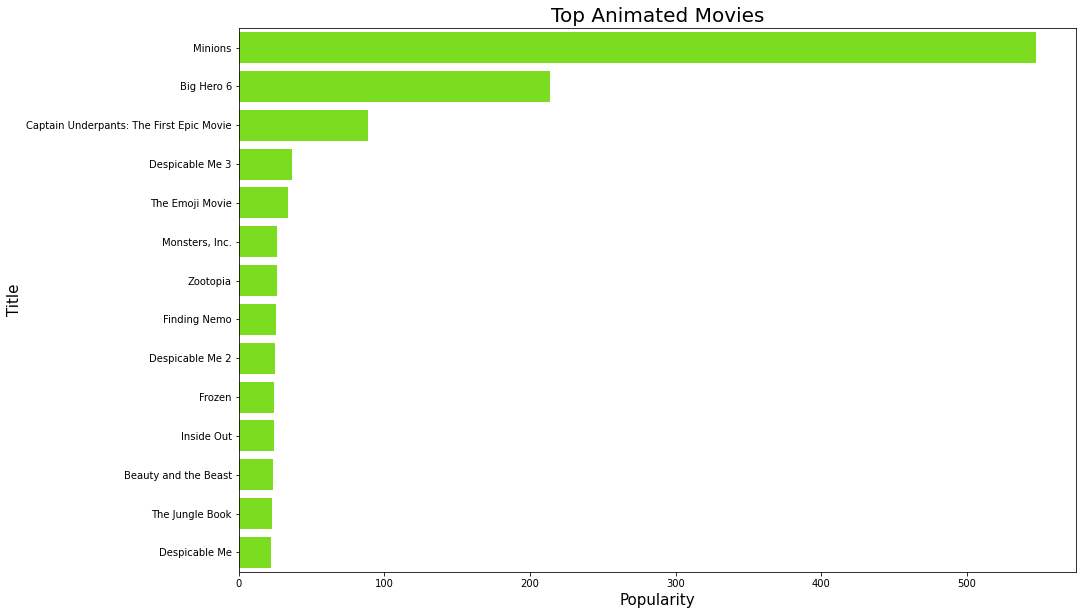

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]

Animated_graph = sns.barplot( movie_genre_popularity_animation["popularity"],movie_genre_popularity_animation.original_title.values, color='lawngreen')
Animated_graph.set_xlabel("Popularity", fontsize = 15)
Animated_graph.set_ylabel("Title", fontsize = 15)
Animated_graph.set_title("Top Animated Movies", fontsize = 20)
plt.show()

**Graph 4**

> The above Bar Chart shows the titles of the **Top Animated Movies** according to their popularity.


In [ ]:
movie_genre_popularity = movie_genre_popularity.head(15)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


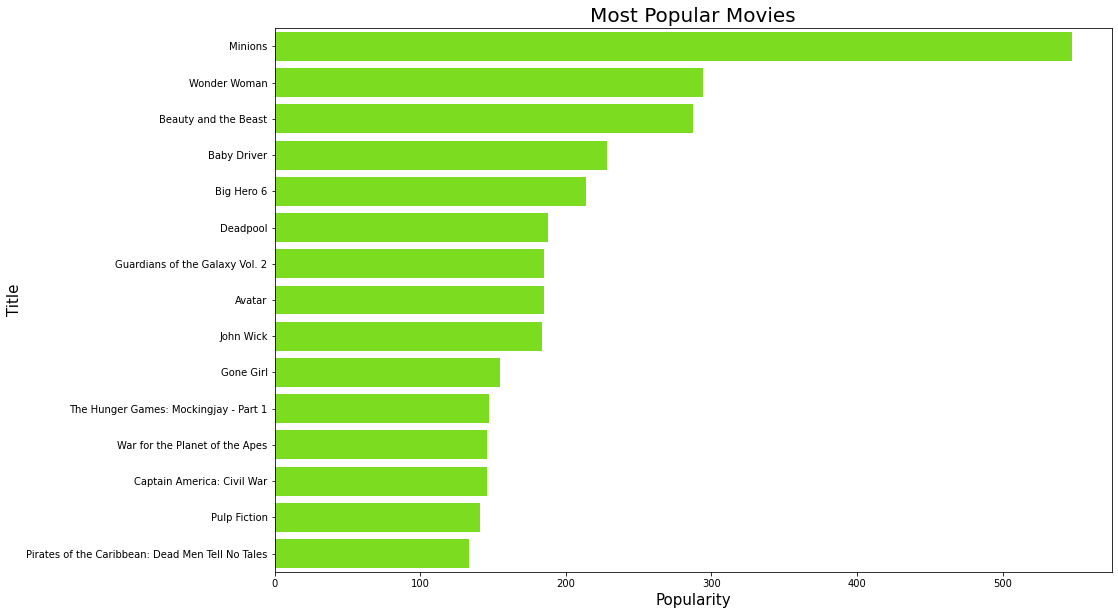

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]

popular_graph = sns.barplot( movie_genre_popularity["popularity"],movie_genre_popularity.original_title.values, color='lawngreen')
popular_graph.set_xlabel("Popularity", fontsize = 15)
popular_graph.set_ylabel("Title", fontsize = 15)
popular_graph.set_title("Most Popular Movies", fontsize = 20)
plt.show()

**Graph 5**

> The above Bar Chart shows the titles of the most popular movies according to their popularity.

In [ ]:
movies_genres = pd.DataFrame()
movies_genres['genres'] = movies.genres
# movies_genres

In [ ]:
# Count of each genre
d = dict()
for i in movies_genres['genres']:
  for j in i:
    if j in d:
      d[j] +=1
    else:
      d[j] = 1
movies_genres_df = pd.DataFrame(d.items(), columns=['genre', 'total'])
movies_genres_df

,genre,total
0,Animation,1573
1,Comedy,9449
2,Family,2160
3,Adventure,2824
4,Fantasy,1897
5,Romance,4735
6,Drama,13904
7,Action,5203
8,Crime,3253
9,Thriller,6119


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


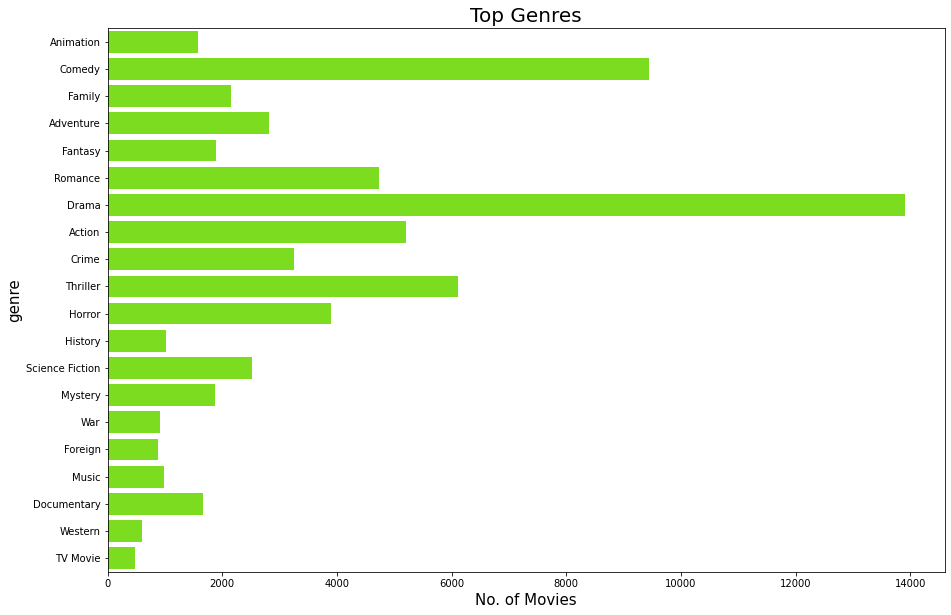

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]

genre_graph = sns.barplot( movies_genres_df["total"],movies_genres_df.genre.values, color='lawngreen')
genre_graph.set_xlabel("No. of Movies", fontsize = 15)
genre_graph.set_ylabel("genre", fontsize = 15)
genre_graph.set_title("Top Genres", fontsize = 20)
plt.show()


**Graph 6**

> The above Bar Chart shows the **Number of Movies** in each genre.

In [ ]:
genre_list = []
lis = movies_genres_df['genre']
for i in lis:
    genre_list.append(i)
# genre_list
movies['genres_bin'] = movies['genres'].apply(lambda x: binary_genres(x))
movies['genres_bin'].head()

0    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: genres_bin, dtype: object

# **Summary of working with Genres**


1.   The Most popular movie is “Minions”.
2.   By Analyzing each genre:<br>
    2.1. Most popular Romance Comedy movie is “Forrest Gump”.<br>
    2.2. Most popular crime and thriller movie is “Baby Driver”.<br>
    2.3. Most popular Action Drama Movie is "Dark Knight".<br>
    2.4. Most popular Animated Movie is "Dark Knight".


3.   Most movies are related to “Drama” genre followed by Comedy and Thriller.


# **Working with Cast**

In [ ]:
movies_cast = pd.DataFrame()
movies_cast['cast'] = movies.cast
movies_cast.dropna(subset=['cast'],inplace=True)
movies_cast

,cast
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,"[Whitney Houston, Angela Bassett, Loretta Devi..."
4,"[Steve Martin, Diane Keaton, Martin Short, Kim..."
...,...
46614,"[Jeanne d'Alcy, Georges Méliès]"
46616,"[Sridevi Kapoor, Sajal Ali, Akshaye Khanna, Na..."
46619,"[Rondo Hatton, Robert Lowery, Virginia Grey, B..."
46623,"[Patrick Bergin, Uma Thurman, David Morrissey,..."


In [ ]:
# Creating df for actors with most appearances.
cast_d = dict()
for i in movies_cast['cast']:
  for j in i:
    if j in cast_d:
      cast_d[j] +=1
    else:
      cast_d[j] = 1

movies_cast_df = pd.DataFrame(cast_d.items(), columns=['cast', 'total'])
movies_cast_df.sort_values('total',ascending=False,inplace=True)
# movies_cast_df
movies_top_cast_df = movies_cast_df.head(15)
movies_top_cast_df.sort_values('total')

,cast,total
2894,Donald Sutherland,87
387,Bruce Willis,87
4490,John Goodman,88
1267,Christopher Walken,88
10640,John Wayne,92
1264,Steve Buscemi,92
82,Danny Trejo,93
4953,Gérard Depardieu,94
1600,Jackie Chan,98
14336,Michael Caine,98


In [ ]:
cast_list = []
cast_lis = movies_cast_df['cast']
cast_tot = movies_cast_df['total']
for i,j in zip(cast_lis,cast_tot):
  if j>100:
    cast_list.append(i)
# cast_list

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


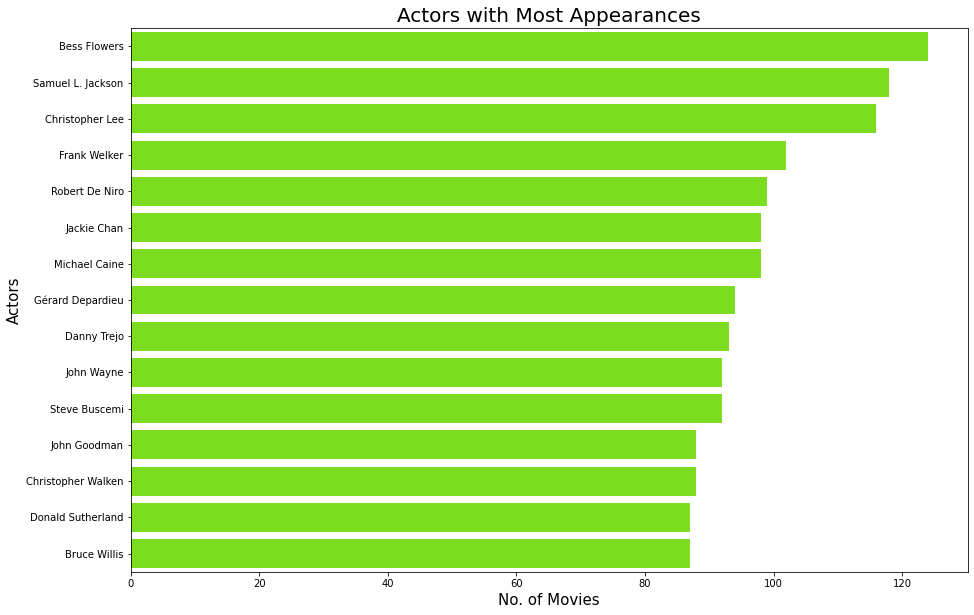

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]

cast_graph = sns.barplot( movies_top_cast_df["total"],movies_top_cast_df.cast, color='lawngreen')
cast_graph.set_xlabel("No. of Movies", fontsize = 15)
cast_graph.set_ylabel("Actors", fontsize = 15)
cast_graph.set_title("Actors with Most Appearances", fontsize = 20)
plt.show()

**Graph 7**

> The above Bar Chart shows the **Actors with Most Appearances**.

In [ ]:
lis_cast_bin = []
for i in movies_cast['cast']:
    c=0
    l = len(i)
    for j in i:
        if l>30:
            if c>2: break
        elif l<=30 and l>20:
            if c>1: break
        elif l<=20:
            if c>0: break
        c+=1
        lis_cast_bin.append(j)

lis_cast_bin = list(set(lis_cast_bin))
len(lis_cast_bin)
    

13901

In [ ]:
movies['cast'].isna().sum()
movies.dropna(subset = ['cast'],inplace=True)

In [ ]:
movies['cast_bin'] = movies['cast'].apply(lambda x: binary_cast(x))
movies['cast_bin'].head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: cast_bin, dtype: object

# **Working with Directors**

In [ ]:
movies['Director']

0          [John Lasseter]
1           [Joe Johnston]
2          [Howard Deutch]
3        [Forest Whitaker]
4          [Charles Shyer]
               ...        
46614     [Georges Méliès]
46616       [Ravi Udyawar]
46619     [Jean Yarbrough]
46623         [John Irvin]
46626     [Mark L. Lester]
Name: Director, Length: 29082, dtype: object

In [ ]:
director_d = dict()
for i in movies['Director']:
  for j in i:
    if j in director_d:
      director_d[j] +=1
    else:
      director_d[j] = 1

movies_director_df = pd.DataFrame(director_d.items(), columns=['director', 'total'])
# movies_director_df
# len(movies_director_df['total'])
movies_director_df.sort_values('total',ascending=False,inplace=True)

In [ ]:
director_list = []
director_lis = movies_director_df['director']
director_tot = movies_director_df['total']
for i,j in zip(director_lis,director_tot):
  if j>1:
    director_list.append(i)

In [ ]:
movies_top_directors_df = movies_director_df.head(15)
movies_top_directors_df.sort_values('total')

,director,total
1364,Buster Keaton,34
563,George Cukor,34
2273,Takashi Miike,34
353,Sidney Lumet,34
473,Jean-Luc Godard,35
97,Clint Eastwood,35
281,Steven Soderbergh,35
572,Michael Curtiz,37
704,Ingmar Bergman,37
15,Martin Scorsese,38


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


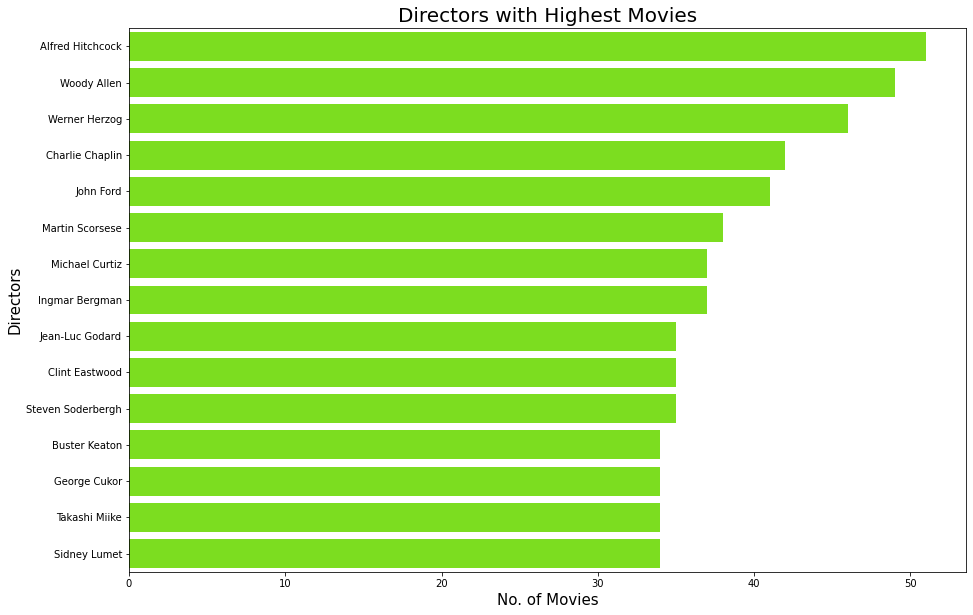

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]

director_graph = sns.barplot( movies_top_directors_df["total"],movies_top_directors_df.director, color='lawngreen')
director_graph.set_xlabel("No. of Movies", fontsize = 15)
director_graph.set_ylabel("Directors", fontsize = 15)
director_graph.set_title("Directors with Highest Movies", fontsize = 20)
plt.show()

**Graph 8**

> The above Bar Chart shows the **Directors with Most Movies**.

In [ ]:
movies['director_bin'] = movies['Director'].apply(lambda x: binary_director(x))
movies['director_bin'].head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: director_bin, dtype: object

# **Working With Keywords**

In [ ]:
keywords_dataset

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence, aging, daug..."
...,...,...
46414,439050,[tragic love]
46415,111109,"[artist, play, pinoy]"
46416,67758,[]
46417,227506,[]


In [ ]:
keywords_list = []
for i in keywords_dataset['keywords']:
    for j in i:
        if j not in keywords_list:
            keywords_list.append(j)
len(keywords_list)

19956

In [ ]:
keywords_dict = dict()
for i in keywords_dataset['keywords']:
    for j in i:
        if j not in keywords_dict:
            keywords_dict[j] = 1
        else:
            keywords_dict[j] +=1

In [ ]:
keywords_df = pd.DataFrame()
keywords_df = pd.DataFrame(keywords_dict.items(), columns=['keywords', 'total'])
keywords_df.sort_values(['total'],ascending=False)

,keywords,total
132,woman director,3115
261,independent film,1930
41,murder,1308
19,based on novel,835
343,musical,734
...,...,...
13704,longest film,1
13702,figher airplane,1
13701,all girl,1
6268,ancient scroll,1


In [ ]:
keywords_list_bin = []
for i in keywords_df.keywords:
    keywords_list_bin.append(i)
# keywords_list_bin
# len(keywords_list_bin)

In [ ]:
movies['keywords_bin'] = movies['keywords'].apply(lambda x: binary_keywords(x))

# **Creating a Machine Learning Model using KNN Algorithm**

The below function is to find distance between 2 points(i.e., Movies) using Cosine Similarity

In [ ]:
def Similarity(movieId1, movieId2):
    a = movies.iloc[movieId1]
    b = movies.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    castA = a['cast_bin']
    castB = b['cast_bin']
    castDistance = spatial.distance.cosine(castA, castB)
    
    directA = a['director_bin']
    directB = b['director_bin']
    directDistance = spatial.distance.cosine(directA, directB)
    
    wordsA = a['keywords_bin']
    wordsB = b['keywords_bin']
    wordsDistance = spatial.distance.cosine(directA, directB)
    return genreDistance + directDistance + castDistance + wordsDistance

In [ ]:
movies.reset_index(inplace=True)

In [ ]:
# Distance between movies with IDs 35 and 37 respectively.
Similarity(35,37)

Movies having Cosine eucledian Distance greater than 1 are generally not similar.  

In [ ]:
# Selecting relevant features
new_id = list(range(0,movies.shape[0]))
movies['new_id']=new_id
movies=movies[['original_title','genres','vote_average','genres_bin','cast_bin','new_id','Director','director_bin','keywords_bin']]
movies.head()

In [ ]:
titles_list = movies['original_title'].tolist()

The Below function is to predict the similar movies using KNN Algorithm.



In [ ]:
def Recommend_movie(movie_name):
    find_close_match = difflib.get_close_matches(movie_name, titles_list)
    print("Do you mean?")
    for ind in range(len(find_close_match)):
      print(ind+1,".",find_close_match[ind])
    req = int(input("Please select Number: "))
    name = find_close_match[req-1]
    new_movie = movies[movies['original_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Movie: ',new_movie.original_title.values[0])
    def getNeighbors(baseMovie, K):
        distances = []
    
        for index, movie in movies.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 15
    avgRating = 0
    neighbors = getNeighbors(new_movie, K)
    
    print('\nRecommended Movies: \n')
    for neighbor in neighbors:
        avgRating = avgRating+movies.iloc[neighbor[0]][2]  
        print( movies.iloc[neighbor[0]][0]+" | Genres: "+str(movies.iloc[neighbor[0]][1]).strip('[]').replace(' ','')+" | Rating: "+str(movies.iloc[neighbor[0]][2]))
    
    # print('\n')
    # avgRating = avgRating/K
    # print('The predicted rating for %s is: %f' %(new_movie['original_title'].values[0],avgRating))
    # print('The actual rating for %s is %f' %(new_movie['original_title'].values[0],new_movie['vote_average']))
    # print("Accuracy: ",(avgRating/new_movie['vote_average'])*100)
    

In [ ]:
Recommend_movie(input('Search movies : '))